In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, I am going to explore the probability diffusion heuristic from Kaplan and Friston's "Planning and Navigation as Active Inference"

In [82]:
environment = ['OOOO',
               'COCO',
               'OOOO',
               'COCG'] # O: open; C: closed; G: goal.
actions = ['left', 'down', 'right', 'up']
env_size = 8 # len(environment)
num_occurrences = 64 # sum(map((lambda x: len(x)), environment))
# print(num_occurrences)
B = np.zeros((num_occurrences, num_occurrences, len(actions)))
# print(B[:, :, 0])

In [83]:
A = np.eye(num_occurrences)
# print(A)

In [84]:
# TODO: We need to adjust this to account for obstacles
for i in range(env_size):
    for j in range(env_size):
        curr_pos = (i * env_size) + j
        # going up
        if i == 0:
            B[curr_pos, curr_pos, 3] = 1.0
        if i < env_size - 1:
            # print(curr_pos, i, j)
            B[curr_pos, curr_pos+env_size, 3] = 1.0

        # going left
        if j == 0:
            B[curr_pos, curr_pos:curr_pos+2, 0] = 1.0
        elif j == env_size - 1:
            pass
            # B[curr_pos, curr_pos-1, 0] = 1.0
        else:
            B[curr_pos, curr_pos+1, 0] = 1.0

    # going right looks like a flip of left horizontally and then vertically
    B[:,:,2] = np.fliplr(np.flipud(B[:,:,0]))

    # going down is up flipped over horizontal and vertical
    B[:, :, 1] = np.fliplr(np.flipud(B[:, :, 3]))
    
# print(B[:,:,0])

In [85]:
# modify the transition function "B" to account for absorbing state: goal
B[:, -1, :] = 0.0
B[-1, -1, :] = 1.0
# print(B[:,:,0])

Now, let's try visualizing our current transition function

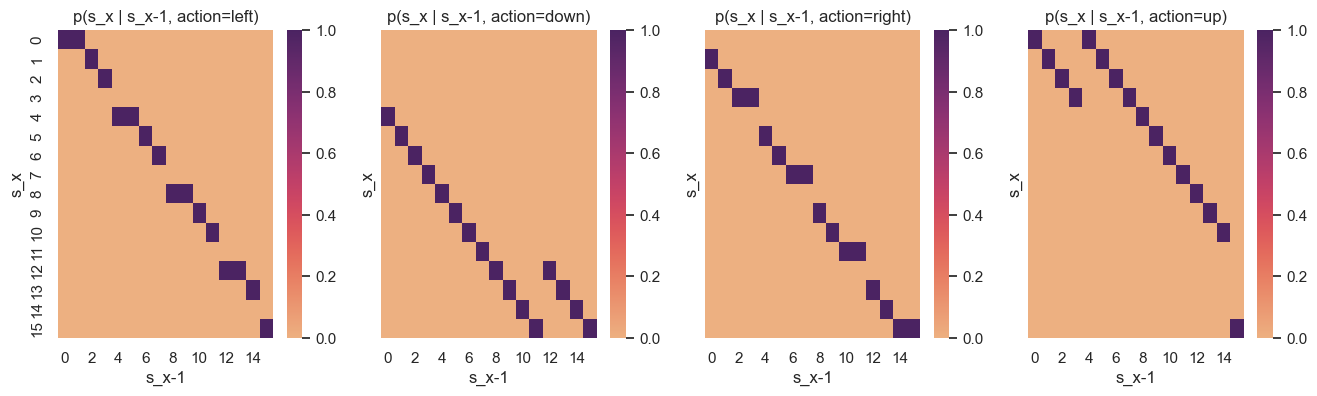

In [61]:
# B /= B.sum(axis=0, keepdims=True)

sns.set_theme()
fig, axes = plt.subplots(1, len(actions), figsize=(16, 4), sharey=True)
color_map = sns.color_palette('flare', as_cmap=True)

for i in range(len(actions)):
    ax = axes[i]
    sns.heatmap(B[:,:,i], cmap=color_map, ax=ax)
    ax.set_title(f'p(s_x | s_x-1, action={actions[i]})')
    ax.set_xlabel(f's_x-1')
    ax.set_ylabel(f's_x')

plt.show()

# "Planning and Navigation as Active Inference" - Kaplan & Friston (2018)
One of the big ideas from my reading was section 7, "Prior preferences, constraints, and goals" where "purposeful" and goal oriented navigation seems to emerge from an agent based on prior preferences, or the C matrix.

The prior preferences are "preferable" observations, like location, or what I am observing. These are the observations the agent would like to spend as much time in as possible. An agent can be equipped with goal oriented behavior, if it's prior preferences are recomputed at each timestep, and a heuristic will be applied to help guide it towards its goals.

Here, I'm going to try to implement and understand it.

#### Purposeful Navigation

The idea is that an agent will choose locations (it is observing) that will lead it towards the goal, i.e. it will want to occupy (and spend most of its time at) the locations on the shortest path to the goal, so we will need to recompute which locations it wants to occupy at every timestep, until it reaches the goal location. As written in the paper

$$
C^1_\tau = -\ln(P(o^1_\tau)) = 16 \cdot [Ts_1 < e^-3] - \ln(Ts_T)
$$

where $Ts_1$ means the starting location vector (or column from B where we want to start from) times the diffused transition matrix T, and $Ts_T$ means the goal location vector times the diffused transition matrix T

How do we calculate T then?

Firstly, Calculate T based on the currently believed structure of the maze or grid, following the definition:
$$
T_{ij} = \begin{cases}
1 - \sum_{i} T_{ij}, & \text{if } i = j \\ 
A_i, & \text{if } \exists u: B^u_{ij} > 0 \\
0, & \text{otherwise}
\end{cases}
$$

Then, diffuse T by:
$$
T = exp(T)
$$

Finally, apply the first introduced equation
$$
C^1_\tau = 16 \cdot [Ts_1 < e^-3] - \ln(Ts_T)
$$

sidenote: the paper is not totally clear if $A_i$ is the row or if there is an error in the spelling.
anyways the implementation is found below.

In [62]:
T = np.zeros((num_occurrences, num_occurrences))
# print(T)

In [63]:
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        if i != j:
            if np.any(B[i, j, :] > 0):
                T[i, j] = np.sum(A[i, :])
            else:
                T[i, j] = 0.0
for i in range(T.shape[0]):
    T[i, i] = 1 - np.sum(T[i, :])
print(T)

[[-1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -2.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -3.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -2.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -2.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -3.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -3.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -1. 

<Axes: >

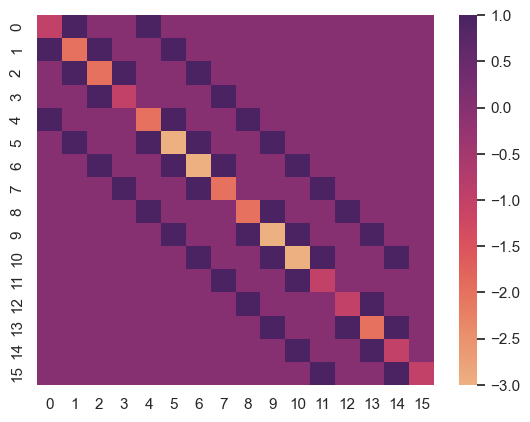

In [64]:
fig, ax = plt.subplots(1, 1)
sns.heatmap(T, ax=ax, cmap=color_map)

<Axes: >

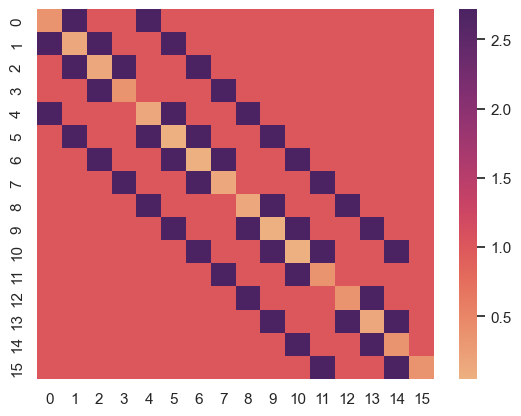

In [65]:
T_new = np.exp(T)
fig, ax = plt.subplots(1, 1)
sns.heatmap(T_new, ax=ax, cmap=color_map)

In [66]:
C = np.zeros(num_occurrences)
print(C)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [67]:
s_start = np.zeros(num_occurrences)
s_start[0] = 1.0

s_goal = np.zeros(num_occurrences)
s_goal[-1] = 1.0
print(s_start)
print(s_goal)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [68]:
np.dot(T_new, s_start)

array([0.36787944, 2.71828183, 1.        , 1.        , 2.71828183,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [69]:
(16 * (np.dot(T_new, s_start) < np.exp(-3)).astype(int))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [70]:
np.log(np.dot(T_new, s_goal))

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.])

In [71]:
C = (16 * (np.dot(T_new, s_start) < np.exp(-3)).astype(int)) - np.log(np.dot(T_new, s_goal))
print(C)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


<Axes: >

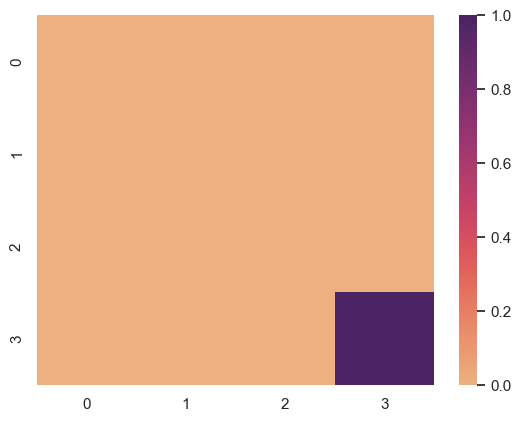

In [72]:
C_grid = np.reshape(C, (env_size, env_size))
fig, ax = plt.subplots(1, 1)
sns.heatmap(C_grid, ax=ax, cmap=color_map)

In [87]:
def recalculate_C(num_occurrences, A, B, current_pos: int, goal_pos: int):
    T = np.zeros((num_occurrences, num_occurrences))
    # print(T)
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            if i != j:
                if np.any(B[i, j, :] > 0):
                    T[i, j] = np.sum(A[i, :])
                else:
                    T[i, j] = 0.0
    for i in range(T.shape[0]):
        T[i, i] = 1 - np.sum(T[i, :])
    T = np.exp(T)
    # print(T)
    C = np.zeros(num_occurrences)
    s_start = np.zeros(num_occurrences)
    s_start[current_pos] = 1.0
    
    s_goal = np.zeros(num_occurrences)
    s_goal[goal_pos] = 1.0
    C = (16 * (np.dot(T, s_start) < np.exp(-3)).astype(int)) - np.log(np.dot(T, s_goal))
    return C

In [90]:
c_1 = recalculate_C(num_occurrences, A, B, current_pos=58, goal_pos=37)
print(f'c_1: {c_1}')
c_2 = recalculate_C(num_occurrences, A, B, current_pos=31, goal_pos=37)
print(f'c_2: {c_2}')
c_3 = recalculate_C(num_occurrences, A, B, current_pos=34, goal_pos=37)
print(f'c_3: {c_3}')
c_4 = recalculate_C(num_occurrences, A, B, current_pos=33, goal_pos=37)
print(f'c_4: {c_4}')

c_1: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
 -1.  3. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
c_2: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
 -1.  3. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
c_3: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
 -1.  3. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
c_4: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
 -1.  3. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0

<Axes: >

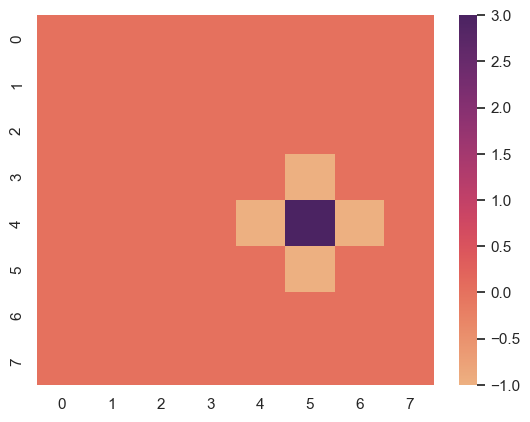

In [91]:
C_grid = np.reshape(c_4, (env_size, env_size))
fig, ax = plt.subplots(1, 1)
sns.heatmap(C_grid, ax=ax, cmap=color_map)